In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd

In [8]:
path_data = 'data/'

In [9]:
pokemon = pd.read_csv(path_data + 'pokemon.csv')
combat = pd.read_csv(path_data + 'combat.csv')
pokemon.head()

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False


In [10]:
combat.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


# Predicting Pokemon battles

I want to use the datasets to create a model that predicts the outcome of Pokémon battles based on the contenders features, such as HP, class, Attack etc.

For training I will use the combat.csv dataset, a list of 50k Pokémon battles and their outcomes (all by their unique identifier, the PID).

## The feature vectors

The PID, being nothing more than an identifier, provides no information about a Pokémons abilities. Instead I will feed the model with all the important informations, creating a **feature vector**


The feature vector of training data has to contain all features necessary to predict who will win. We'll exclude the following

 - the PID
 - the Name
 - and the legendary status (while legendary Pokémon certainly are strong, the legendary stat *itself* does not change a Pokemons battle performance)

To proceed I will

 1. encode the categorical features so that they can be put into a vector
 2. create a pd.dataframe that contains all the relevant information
 3. actually create out feature vector by pairing the information of two Pokemon 
    and storing them in one vector.
 4. take the pairings from 'combat' and add the battle result as label

In [11]:
# 1. Encoding categorical features
# that is usually done as one-hot-encoding:
# for N different features, a N-dimensional vector is created containing zeros and ones
# that indicate feature

# pandas offers a way to do this: pd.get_dummies
class_1 = pd.get_dummies(pokemon['Class 1'], prefix='Class')
class_2 = pd.get_dummies(pokemon['Class 2'], prefix='Class')
# If a Pokemon does not have a second class, this will simply be encoded by the zero-vector
# this should be fine, a class adds strengths and weaknesses in a combat-pairing
# and the absence of a second Class simply does not yield any information

In [12]:
# defining a pd dataframe containing the desired class-information:

# I simply add them! Instead of a one-hot encoding, that would be a one- or two-hot encoding, so to say
# The presence of a class matters no matter if it is first or second, 
# and the absence of a class is simply the absence of information relevant to the task at hand
# also: I keep the number of input features smaller, instead of 36, we'll just have 18 that 
# each correspond to the presence or absence of a Class

classes = class_1.add(class_2, fill_value=0)

# The first Pokemon in the dataframe (Bulbasaur) incidentally has two Classes: 
# Grass and Poison
classes.loc[[0]]

,Class_Bug,Class_Dark,Class_Dragon,Class_Electric,Class_Fairy,Class_Fighting,Class_Fire,Class_Flying,Class_Ghost,Class_Grass,Class_Ground,Class_Ice,Class_Normal,Class_Poison,Class_Psychic,Class_Rock,Class_Steel,Class_Water
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [13]:
# 2. I want to add the other stats, I do this by adding 'pokemon' and dropping all columns 
# that are either irrelevant or already implemented
all_others = pokemon.drop(columns=['Class 1', 'Class 2', 'pid', 'Name', 'Legendary'])
new = pd.concat([classes, all_others], axis=1)

new.head()

,Class_Bug,Class_Dark,Class_Dragon,Class_Electric,Class_Fairy,Class_Fighting,Class_Fire,Class_Flying,Class_Ghost,Class_Grass,...,Class_Psychic,Class_Rock,Class_Steel,Class_Water,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,45,49,49,65,65,45
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,60,62,63,80,80,60
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,80,82,83,100,100,80
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,80,100,123,122,120,80
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,39,52,43,60,50,65


The dataframe 'new' is exactly what is needed:

It is the pokemon dataframe without the irrelevant information and categorical features encoded

In [14]:
# 3. Creating the training set

X = []
y = []

#for k in range(10):
for k in range(len(combat)):
    vec = []
    # now when creating the feature vector we want to enter the features that belong 
    # to the two pokemon in that entry in the combat list.
    # the pids of those pokemon are:
    pid_1 = combat['First_pokemon'][k]
    pid_2 = combat['Second_pokemon'][k]
    winner = combat['Winner'][k]
    # now we need the index belonging to the pokemon with these pids
    # the lazy way is to do this by noticing that: index = pid-1
    id_1 = pid_1 - 1
    id_2 = pid_2 - 1
    
    # now we can append all the relevant features to our feature vector:
    # for the first Pokemon:
    for col in new.columns:
        vec.append(new[col][id_1])
    # and for the second Pokemon:     
    for col in new.columns:
        vec.append(new[col][id_2])
    # the order of features should be entirely irrelevant here, 
    # but it's a bit more understandable looping twice

    # append the new feature vector to the training set
    X.append(vec)

    
    # for the label:
    if winner == pid_1:
        y.append(0)
    elif winner == pid_2:
        y.append(1)
    else:
        print('Error.')
        

In [15]:
n = 0
print(X[n])
print()
print(y[n])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 50, 64, 50, 45, 50, 41, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 70, 70, 40, 60, 40, 60]

1


In [16]:
# Just to test:
# the first pairing was the following:
combat.loc[0]

First_pokemon     266
Second_pokemon    298
Winner            298
Name: 0, dtype: int64

In [17]:
# the pids correspond to the pokemon
pokemon.loc[266 - 1]

pid               266
Name         Larvitar
Class 1          Rock
Class 2        Ground
HP                 50
Attack             64
Defense            50
Sp. Atk            45
Sp. Def            50
Speed              41
Legendary       False
Name: 265, dtype: object

In [18]:
# and

In [19]:
pokemon.loc[298 - 1]

pid              298
Name         Nuzleaf
Class 1        Grass
Class 2         Dark
HP                70
Attack            70
Defense           40
Sp. Atk           60
Sp. Def           40
Speed             60
Legendary      False
Name: 297, dtype: object

In [15]:
# If we look into the valeus of X[0], we'll find the right stats, just the way we wanted to encode them!

In [16]:
X = np.array(X)
y = np.array(y)

print('We now have training data of the shapes X={:} and y={:}'.format(X.shape, y.shape))

We now have training data of the shapes X=(50000, 48) and y=(50000,)


## Setting up a random forest model

The task is to ***classify*** the Pokémon as to who the winner is based on the stats

In [23]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets

N = len(combat)
split = int(0.9*N)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = split)

X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [24]:
print('  Training Data Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print()
print('   Testing Data Shape:', X_test.shape)
print(' Testing Labels Shape:', y_test.shape)

  Training Data Shape: (45000, 48)
Training Labels Shape: (45000,)

   Testing Data Shape: (5000, 48)
 Testing Labels Shape: (5000,)


In [26]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 10, max_depth=10, random_state = 123, verbose=1)

# Train the model on training data
history = model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


In [21]:
# Use the forest's predict method on the test data
predictions = model.predict(X_test)
# print(predictions)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('MAE: {:.2f}'.format(np.mean(errors)))

MAE: 0.10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


One could naively attempt to tweak the models hyperparameters for the Mean Absolute Error to be as small as possible.

## But there a problem!

The prupose of the testing set is to predict out-of-sample performance of the model. Our model might fit the training data perfectly and yet perform poorly on other data as the model has learned **idiosyncrasies specific to the training set (overfitting)** - the test sets purpose is to detect that and thus guaranteeing success on data that is unlabeled.

By selectinghyper parameters based on test set performance, we hijack that mechanism by teaching the model something about the test set and thus **effectively integrating the test set into the training set**.

If we want to select hyper parametes, there's a better way to do that:

## Cross-validation

Which leaves the test set untouched - as it should be - and instead searches for the best hyperparameter "testing" on a **validation set** instead (which is a part of the training set).

The K-fold cross validation divides the training set into $K$ subsets and performs training ok $K-1$ of them and validates the model on the remaining subset.

Scikit's GridSearchCV takes a dictionary of parameters, transforms them into a parameter grid and runs the model. Based on performance on the validation set it will find the best hyperparameter set.


In [27]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid
param_grid = { 'max_depth': [2, 4, 6, 10, 20, 50],
            'n_estimators': [10, 25, 50, 100, 200]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

In [28]:
%%time 
grid_search.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 8.73 s, sys: 274 ms, total: 9 s
Wall time: 1min 32s


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=123,
                                    

In [29]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'max_depth': 50, 'n_estimators': 200}


We'll now train the model using exactly those parameters

In [30]:
model = RandomForestClassifier(random_state = 123, **best_parameters)

# Train the model on training data
history = model.fit(X_train, y_train)

And now we can test performance on the test set

In [31]:
# Use the forest's predict method on the test data
predictions = model.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)

print('MAE: {:.2f}'.format(np.mean(errors)))

MAE: 0.06


## Importances

The scikit documentation provides functionality for evaluating the features that are **most indicative** of being classified as a winner.

In [40]:
# But before that it is convenient to decode what the actual features are that correspond to their indeces

# This will be done the exactly way the features were composed: (stats Pokemon 1, stats Pokemon 2)

single_features = new.columns
features = []

for k in range(len(single_features)):
    features.append(single_features[k] + ' (P1)')

for k in range(len(single_features)):
    features.append(single_features[k] + ' (P2)')

# features go from 0 to 47 corresponding to the indices
# those are made up by the data of two pokemon:
# n = 0-23

# each index 
# n = n+24 (but for Pokemon 2)

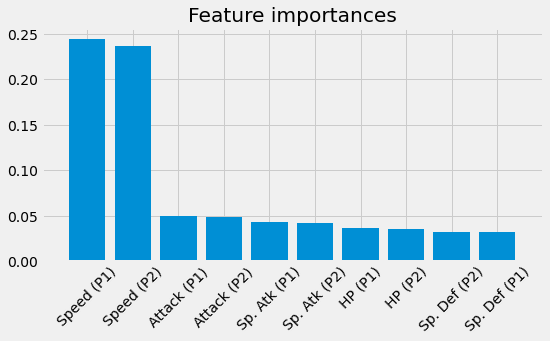

In [42]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

num = 10

indices = indices[:num]

labels = []
for k in range(num):
    labels.append(features[indices[k]])

    
    
# Plot the impurity-based feature importances of the model
plt.figure(figsize=(8,4))
plt.title("Feature importances")
plt.bar(range(num), importances[indices], color='C0', align="center")
#plt.xticks(range(num), indices)
plt.xticks(range(num), labels, rotation=45)
plt.xlim([-1, num])
plt.show()

## Note: 

it is not very elegant to have two features here (i.e. Pokemon 1 and Pokemon 2). I assume the most elegant way would be to average over the two importances and use that number instead.

I have done this here in a slightly bulky way:

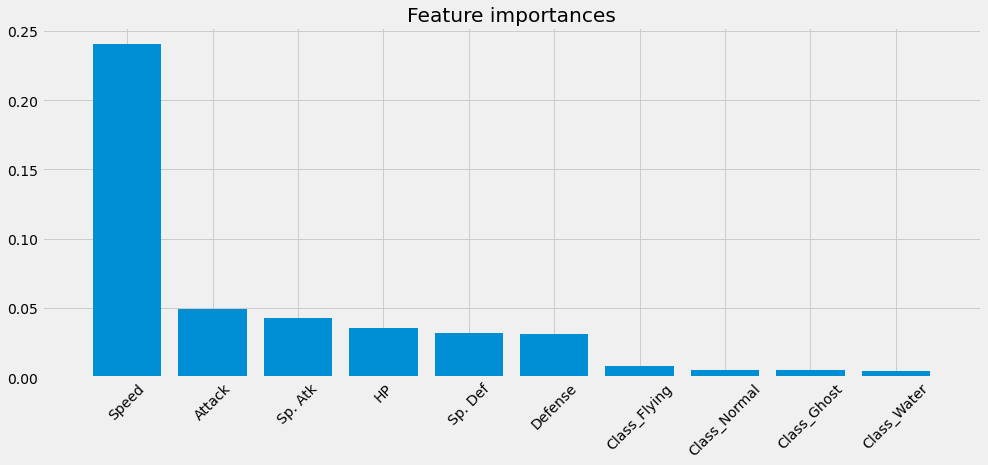

In [44]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# we want to create a new set of importances
# that contains the importances averaged

importances_new = np.zeros(24)
indices_new = []
for k in range(len(indices)):
    ind = indices[k]
    if ind < 24:
        indices_new.append(ind)
        ind_2 = ind+24   # this is the brother index
        imp_1 = importances[ind]
        imp_2 = importances[ind_2]
        avg = (imp_1 + imp_2)/2
        importances_new[ind] = avg

num = 10
indices_new = np.array(indices_new)[:num]

labels = []
for k in range(num):
    labels.append(features[indices_new[k]][:-5])
    
plt.figure(figsize=(15,6))
plt.title("Feature importances")
plt.bar(range(num), importances_new[indices_new], color='C0', align="center")
plt.xticks(range(num), labels, rotation=45)
plt.xlim([-1, num])
plt.show()

This is interesting, 'Speed' is by far the most important stat for a Pokemon to have! Generally an important consideration in Pokemon battles is a favourable pairing of Classes.

The game is however structured that the Classes overall are of similar strength in the sense, 
that each class has a similar number of strengths and weaknesses.

According to this analysis, the flying class is the best, the margin however is insignificant.

In [46]:
# Just out of curiosity: what are the best Pokemon in Generation I?
# those are incidentally the first 166 in the dataset
temp = pokemon[:166]

# and I'll remove the 'Mega' Pokemon
index = temp['Name'].str.startswith('Mega', na = False) # 'True' if names start with 'Mega'
index = [not k for k in index] # flipping the values
temp = temp[index]

temp = temp.nlargest(n=10, columns='Speed', keep='all')

temp

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
109,110,Electrode,Electric,NaN,60,50,70,80,80,140,False
146,147,Jolteon,Electric,NaN,65,65,60,110,95,130,False
153,154,Aerodactyl,Rock,Flying,80,105,65,60,75,130,False
162,163,Mewtwo,Psychic,NaN,106,110,90,154,90,130,True
56,57,Dugtrio,Ground,NaN,35,80,50,50,70,120,False
70,71,Alakazam,Psychic,NaN,55,50,45,135,95,120,False
58,59,Persian,Normal,NaN,65,70,60,65,65,115,False
130,131,Starmie,Water,Psychic,60,75,85,100,85,115,False
31,32,Raichu,Electric,NaN,60,90,55,90,80,110,False
101,102,Gengar,Ghost,Poison,60,65,60,130,75,110,False
